<a href="https://colab.research.google.com/github/AlexAlexeyuk/Alexander.Alexeyuk/blob/ready/wrong_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
!pip install colorama
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier
!pip install h2o
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 37 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unknownUser_fhx0qq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.000 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [379]:
df = pd.read_csv('/content/drive/MyDrive/test/covid_data.csv')
df = df.drop('Unnamed: 0', axis=1)

In [291]:
cleaned_df = df.copy()

In [380]:
# разделяем набор данных на тренировочную, тестовую и валидационную части и нормализуем данные
X = df.drop('Ab_ind', axis=1)  
Y = df['Ab_ind']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, stratify = Y, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, stratify = Y_train, random_state = 42)
train = X_train.copy()
test = X_test.copy()
valid = X_val.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)
valid = h2o.H2OFrame(valid)
Y = h2o.H2OFrame(Y_train.reset_index())
V = h2o.H2OFrame(Y_val.reset_index())
T = h2o.H2OFrame(Y_test.reset_index())
train['target'] = Y['Ab_ind']
valid['target'] = V['Ab_ind']
test['target'] = T['Ab_ind']

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [105]:
predictors = train.col_names
predictors.remove('target')

train['target'] = train['target'].asfactor()
valid['target'] = valid['target'].asfactor()
target  = 'target'
hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
gbm_final_grid = H2OGradientBoostingEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## we use learn rate with annealing for a fast scan
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True,
    )
final_grid = H2OGridSearch(
    gbm_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = test, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
sorted_gbm_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
best_gbm = sorted_gbm_grid.models[0]
best_gbm_perf_valid = best_gbm.model_performance(valid)
best_gbm_perf_test = best_gbm.model_performance(test)
params_list = []
for key, value in best_gbm.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_gbm_perf_valid

#best_gbm_perf_valid.aucpr(), best_gbm_perf_test.aucpr(), 

█████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1467169360589259
RMSE: 0.3830364683146057
LogLoss: 0.481202487867306
Mean Per-Class Error: 0.3388157894736842
AUC: 0.6779970760233919
AUCPR: 0.2688405349796957
Gini: 0.35599415204678375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04226870576817366: 


,,0,1,Error,Rate
0,0,51.0,63.0,0.5526,(63.0/114.0)
1,1,3.0,21.0,0.125,(3.0/24.0)
2,Total,54.0,84.0,0.4783,(66.0/138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.042269,0.388889,83.0
1,max f2,0.042269,0.583333,83.0
2,max f0point5,0.276409,0.384615,19.0
3,max accuracy,0.738337,0.818841,0.0
4,max precision,0.319702,0.400000,14.0
5,max recall,0.020397,1.000000,114.0
6,max specificity,0.738337,0.991228,0.0
7,max absolute_mcc,0.042269,0.250365,83.0
8,max min_per_class_accuracy,0.082723,0.587719,61.0
9,max mean_per_class_accuracy,0.042269,0.661184,83.0



Gains/Lift Table: Avg response rate: 17.39 %, avg score: 12.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014493,0.645237,0.000000,0.000000,0.000000,0.693762,0.000000,0.693762,0.000000,0.000000,-100.000000,-100.000000,-0.017544
1,2,0.021739,0.600639,5.750000,1.916667,1.000000,0.638512,0.333333,0.675345,0.041667,0.041667,475.000000,91.666667,0.024123
2,3,0.036232,0.543895,0.000000,1.150000,0.000000,0.566857,0.200000,0.631950,0.000000,0.041667,-100.000000,15.000000,0.006579
3,4,0.043478,0.505901,0.000000,0.958333,0.000000,0.523775,0.166667,0.613921,0.000000,0.041667,-100.000000,-4.166667,-0.002193
4,5,0.050725,0.480906,5.750000,1.642857,1.000000,0.486539,0.285714,0.595723,0.041667,0.083333,475.000000,64.285714,0.039474
5,6,0.101449,0.322406,2.464286,2.053571,0.428571,0.385428,0.357143,0.490575,0.125000,0.208333,146.428571,105.357143,0.129386
6,7,0.152174,0.251612,2.464286,2.190476,0.428571,0.290681,0.380952,0.423944,0.125000,0.333333,146.428571,119.047619,0.219298
7,8,0.202899,0.171171,0.821429,1.848214,0.142857,0.212990,0.321429,0.371205,0.041667,0.375000,-17.857143,84.821429,0.208333
8,9,0.304348,0.121397,0.821429,1.505952,0.142857,0.138985,0.261905,0.293799,0.083333,0.458333,-17.857143,50.595238,0.186404
9,10,0.398551,0.095964,0.884615,1.359091,0.153846,0.107155,0.236364,0.249683,0.083333,0.541667,-11.538462,35.909091,0.173246


In [370]:
h2o_GM_model_prediction = final_grid[0].predict(valid)
h2o_GM_model_prediction_test = final_grid[0].predict(test)
h2o_GM_model_prediction = h2o.h2o.as_list(h2o_GM_model_prediction, use_pandas=True)
h2o_GM_model_prediction_test = h2o.h2o.as_list(h2o_GM_model_prediction_test, use_pandas=True)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [113]:
hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
xgb_final_grid = H2OGradientBoostingEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## we use learn rate with annealing for a fast scan
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True
    )
final_grid = H2OGridSearch(
    xgb_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
sorted_xgb_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
best_xgb = sorted_xgb_grid.models[0]
best_xgb_perf_valid = best_xgb.model_performance(valid)
best_xgb_perf_test = best_xgb.model_performance(test)
params_list = []
for key, value in best_xgb.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_xgb_perf_valid
#best_xgb_perf_valid.aucpr(), best_xgb_perf_test.aucpr(), params_list

gbm Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.149308480278695
RMSE: 0.3864045551992044
LogLoss: 0.4992122322665788
Mean Per-Class Error: 0.32894736842105265
AUC: 0.6999269005847953
AUCPR: 0.28621036795431604
Gini: 0.3998538011695907

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14921756272535255: 


,,0,1,Error,Rate
0,0,94.0,20.0,0.1754,(20.0/114.0)
1,1,13.0,11.0,0.5417,(13.0/24.0)
2,Total,107.0,31.0,0.2391,(33.0/138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.149218,0.400000,30.0
1,max f2,0.013807,0.588235,107.0
2,max f0point5,0.368134,0.375000,13.0
3,max accuracy,0.781739,0.826087,1.0
4,max precision,0.781739,0.500000,1.0
5,max recall,0.013807,1.000000,107.0
6,max specificity,0.875822,0.991228,0.0
7,max absolute_mcc,0.040496,0.260684,75.0
8,max min_per_class_accuracy,0.063331,0.605263,59.0
9,max mean_per_class_accuracy,0.040496,0.671053,75.0



Gains/Lift Table: Avg response rate: 17.39 %, avg score: 11.78 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014493,0.770612,2.875000,2.875000,0.500000,0.828780,0.500000,0.828780,0.041667,0.041667,187.500000,187.500000,0.032895
1,2,0.021739,0.640457,0.000000,1.916667,0.000000,0.751666,0.333333,0.803076,0.000000,0.041667,-100.000000,91.666667,0.024123
2,3,0.036232,0.564791,0.000000,1.150000,0.000000,0.585626,0.200000,0.716096,0.000000,0.041667,-100.000000,15.000000,0.006579
3,4,0.043478,0.516264,0.000000,0.958333,0.000000,0.523699,0.166667,0.684030,0.000000,0.041667,-100.000000,-4.166667,-0.002193
4,5,0.050725,0.507031,5.750000,1.642857,1.000000,0.508209,0.285714,0.658912,0.041667,0.083333,475.000000,64.285714,0.039474
5,6,0.101449,0.361556,3.285714,2.464286,0.571429,0.423028,0.428571,0.540970,0.166667,0.250000,228.571429,146.428571,0.179825
6,7,0.152174,0.268731,0.821429,1.916667,0.142857,0.323568,0.333333,0.468503,0.041667,0.291667,-17.857143,91.666667,0.168860
7,8,0.202899,0.163450,1.642857,1.848214,0.285714,0.196818,0.321429,0.400582,0.083333,0.375000,64.285714,84.821429,0.208333
8,9,0.304348,0.099781,1.642857,1.779762,0.285714,0.131654,0.309524,0.310939,0.166667,0.541667,64.285714,77.976190,0.287281
9,10,0.398551,0.069563,0.442308,1.463636,0.076923,0.079747,0.254545,0.256294,0.041667,0.583333,-55.769231,46.363636,0.223684


In [371]:
h2o_XGB_model_prediction = final_grid[0].predict(valid)
h2o_XGB_model_prediction_test = final_grid[0].predict(test)
h2o_XGB_model_prediction = h2o.h2o.as_list(h2o_XGB_model_prediction, use_pandas=True)
h2o_XGB_model_prediction_test = h2o.h2o.as_list(h2o_XGB_model_prediction_test, use_pandas=True)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [115]:
 hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
drf_final_grid = H2ORandomForestEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True)
final_grid = H2OGridSearch(
    drf_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
sorted_drf_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
best_drf = sorted_drf_grid.models[0]
best_drf_perf_valid = best_drf.model_performance(valid)
best_drf_perf_test = best_drf.model_performance(test)
params_list = []
for key, value in best_drf.params.items():
    params_list.append(str(key)+" = "+str(value['actual']))
best_drf_perf_valid#best_drf_perf_valid.aucpr(), best_drf_perf_test.aucpr(), params_list

drf Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.14008950345587773
RMSE: 0.37428532359134487
LogLoss: 0.4511848909987382
Mean Per-Class Error: 0.36403508771929827
AUC: 0.6615497076023392
AUCPR: 0.2807427108171662
Gini: 0.32309941520467844

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1751525234340959: 


,,0,1,Error,Rate
0,0,99.0,15.0,0.1316,(15.0/114.0)
1,1,15.0,9.0,0.625,(15.0/24.0)
2,Total,114.0,24.0,0.2174,(30.0/138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.175153,0.375000,23.0
1,max f2,0.067389,0.575000,103.0
2,max f0point5,0.271015,0.416667,11.0
3,max accuracy,0.281831,0.826087,9.0
4,max precision,0.281831,0.500000,9.0
5,max recall,0.044555,1.000000,131.0
6,max specificity,0.521369,0.991228,0.0
7,max absolute_mcc,0.271015,0.265497,11.0
8,max min_per_class_accuracy,0.108256,0.583333,58.0
9,max mean_per_class_accuracy,0.086306,0.635965,83.0



Gains/Lift Table: Avg response rate: 17.39 %, avg score: 12.51 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014493,0.438819,0.000000,0.000000,0.000000,0.483905,0.000000,0.483905,0.000000,0.000000,-100.000000,-100.000000,-0.017544
1,2,0.021739,0.404524,0.000000,0.000000,0.000000,0.425841,0.000000,0.464550,0.000000,0.000000,-100.000000,-100.000000,-0.026316
2,3,0.036232,0.392436,2.875000,1.150000,0.500000,0.394863,0.200000,0.436675,0.041667,0.041667,187.500000,15.000000,0.006579
3,4,0.043478,0.377785,5.750000,1.916667,1.000000,0.390360,0.333333,0.428956,0.041667,0.083333,475.000000,91.666667,0.048246
4,5,0.050725,0.333775,0.000000,1.642857,0.000000,0.364163,0.285714,0.419700,0.000000,0.083333,-100.000000,64.285714,0.039474
5,6,0.101449,0.241733,3.285714,2.464286,0.571429,0.279185,0.428571,0.349443,0.166667,0.250000,228.571429,146.428571,0.179825
6,7,0.152174,0.183235,1.642857,2.190476,0.285714,0.203745,0.380952,0.300877,0.083333,0.333333,64.285714,119.047619,0.219298
7,8,0.202899,0.164655,0.821429,1.848214,0.142857,0.172392,0.321429,0.268756,0.041667,0.375000,-17.857143,84.821429,0.208333
8,9,0.304348,0.129730,1.232143,1.642857,0.214286,0.144605,0.285714,0.227372,0.125000,0.500000,23.214286,64.285714,0.236842
9,10,0.398551,0.110362,0.000000,1.254545,0.000000,0.120357,0.218182,0.202078,0.000000,0.500000,-100.000000,25.454545,0.122807


In [372]:
h2o_RF_model_prediction = final_grid[0].predict(valid)
h2o_RF_model_prediction_test = final_grid[0].predict(test)
h2o_RF_model_prediction = h2o.h2o.as_list(h2o_RF_model_prediction, use_pandas=True)
h2o_RF_model_prediction_test = h2o.h2o.as_list(h2o_RF_model_prediction_test, use_pandas=True)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [381]:
def all_estimators(X_train, X_test, X_valid, Y_train, Y_test, Y_valid):
  """Функция - все оценщики

  На вход подаются уже отскалированные данные: тренировочная, тестовая и 
  валидационная подвыборки.

  два словаря с предсказаниями: первый словарь предстаказния на тестовой, 
  второй - на валидационной выборке
  
  """
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  log_reg = LogisticRegression(C=5, 
                             tol=0.001,  
                             solver = 'sag', 
                             class_weight = {0:.99, 1:16},
                             max_iter=200,
                             random_state=123,
                             n_jobs=-1
                             )
  log_reg.fit(X_train, Y_train)
  log_reg_pred = log_reg.predict(X_val)
  log_reg_pred_test = log_reg.predict(X_test)
  # подбор параметров происходил при помощи GridSearch с кросс-валидацией
  sv_clf = SVC(C=10, 
             gamma=0.001, 
             kernel='rbf', 
             class_weight={0:1, 1:11},
             random_state=123
            )
  sv_clf.fit(X_train, Y_train)
  sv_clf_pred = sv_clf.predict(X_val)
  sv_clf_pred_test = sv_clf.predict(X_test)
  # print('SVM conf{0}'.format(confusion_matrix(Y_val, sv_clf_pred)))
  # SVM_perfomance = sv_clf_pred

  model = CatBoostClassifier(
    eval_metric='F1',
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    class_weights = {0:1, 1:66}
    )
  model.fit(
    X_train, Y_train,
    
    verbose=False,
    plot=True
    )
  cat_pred_val = model.predict(data=X_val)
  cat_pred_test = model.predict(data=X_test)
  #confusion_matrix(Y_val, model.predict(data=X_val))
  # подбор параметров осуществлялся при помощи библиотеки FLAML
  lg=LGBMClassifier(colsample_bytree=0.9901173566841761, learning_rate=1.0,
               max_bin=511, min_child_weight=0.9842705371351147,
               n_estimators=19, num_leaves=8, objective='binary',
               reg_alpha=4.5697209030862906e-06,
               reg_lambda=0.19094909947197827, class_weight = {0:.02, 1:3.8}
    )
  lg.fit(X_train,Y_train)
  ypred_val = lg.predict(X_val)
  ypred_test = lg.predict(X_test)
  # print('With score : ',confusion_matrix(Y_val,ypred))
  all_pred_test = {'Logistic': log_reg_pred_test, "SVM": sv_clf_pred_test,
                   "CatBoost": cat_pred_test, "LGBM": ypred_test,
                   "Actual_labels": Y_test
                   }
  #all_pred_test = pd.DataFrame(all_pred_test)
  all_pred_valid = {'Logistic': log_reg_pred, "SVM": sv_clf_pred, 
                    "CatBoost": cat_pred_val,"LGBM": ypred_val,
                    "Actual_labels": Y_val}
  #all_pred_valid = pd.DataFrame(all_pred_valid)
  return all_pred_test, all_pred_valid

In [382]:
test_matrix, valid_matrix = all_estimators(X_train=X_train, X_test=X_test, X_valid=X_val,Y_train=Y_train, Y_test=Y_test, Y_valid=Y_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [383]:
valid_matrix

{'Actual_labels': 137    0
 267    0
 113    0
 701    0
 526    1
 86     1
 433    0
 532    1
 533    0
 489    0
 341    0
 148    0
 304    0
 308    0
 595    0
 309    0
 818    1
 89     1
 264    0
 253    0
 837    0
 195    1
 348    0
 302    0
 26     1
 158    0
 618    0
 488    0
 613    0
 242    1
 317    0
 426    0
 705    0
 9      0
 270    0
 353    0
 294    0
 466    0
 179    0
 507    1
 375    0
 639    0
 782    0
 644    0
 745    0
 4      1
 432    0
 857    0
 742    0
 368    0
 281    0
 330    0
 810    1
 182    1
 362    0
 757    0
 377    0
 708    0
 171    0
 357    0
 169    0
 279    1
 154    0
 229    0
 128    0
 338    0
 211    0
 434    0
 440    0
 848    0
 194    0
 589    0
 5      0
 35     0
 695    0
 13     0
 265    0
 232    0
 0      0
 345    0
 87     1
 830    1
 631    0
 166    0
 410    0
 536    0
 289    0
 704    0
 758    1
 200    0
 861    0
 379    0
 231    0
 278    0
 788    0
 859    0
 684    0
 250    0
 84

In [224]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cleaned_df = df.copy()

In [ ]:
# # Use a utility from sklearn to split and shuffle our dataset.
# train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
# train_df, val_df = train_test_split(train_df, test_size=0.2)

# # Form np arrays of labels and features.
# train_labels = np.array(train_df.pop('Ab_ind'))

# val_labels = np.array(val_df.pop('Ab_ind'))
# test_labels = np.array(test_df.pop('Ab_ind'))

# train_features = np.array(train_df)
# val_features = np.array(val_df)
# test_features = np.array(test_df)

In [296]:
train_features = np.array(X_train)
bool_train_labels = train_labels != 0
val_features = np.array(X_val)
test_features = np.array(X_test)
train_labels = np.array(Y_train)
val_labels = np.array(Y_val)
test_labels = np.array(Y_test)

In [297]:
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (552,)
Validation labels shape: (138,)
Test labels shape: (173,)
Training features shape: (552, 24)
Validation features shape: (138, 24)
Test features shape: (173, 24)


In [298]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [299]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [300]:
model = make_model()
model.summary()
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
Loss: 0.5083


In [301]:
neg, pos = np.bincount(df['Ab_ind'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
initial_bias = np.log([pos/neg])
initial_bias

Examples:
    Total: 863
    Positive: 148 (17.15% of total)



array([-1.57507027])

In [302]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.06850937],
       [0.15655598],
       [0.14459687],
       [0.10924497],
       [0.04339141],
       [0.06036085],
       [0.11684477],
       [0.17503539],
       [0.06972724],
       [0.1813004 ]], dtype=float32)

In [303]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5748


In [304]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [305]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [306]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [307]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

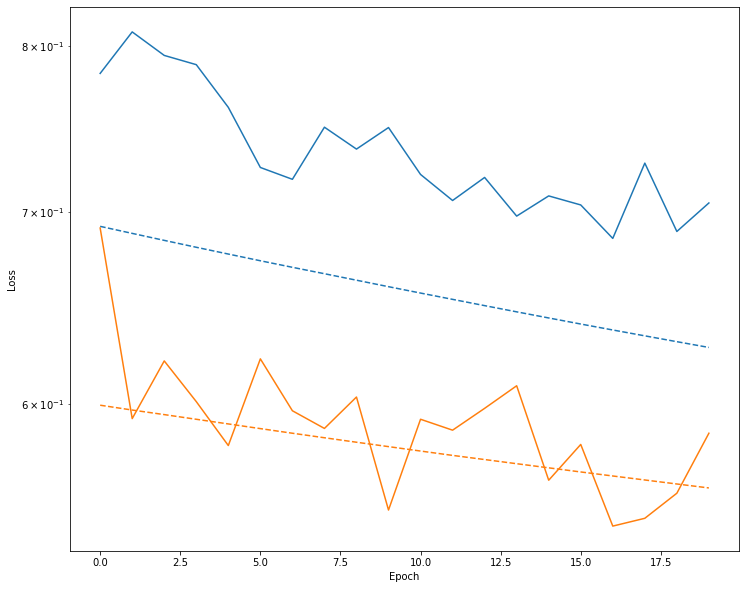

In [308]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [309]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6844 - tp: 1.0000 - fp: 22.0000 - tn: 550.0000 - fn: 117.0000 - accuracy: 0.7986 - precision: 0.0435 - recall: 0.0085 - auc: 0.3628 - val_loss: 0.5993 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 113.0000 - val_fn: 24.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3337
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 0.6267 - tp: 2.0000 - fp: 17.0000 - tn: 441.0000 - fn: 92.0000 - accuracy: 0.8025 - precision: 0.1053 - recall: 0.0213 - auc: 0.4010 - val_loss: 0.5968 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 113.0000 - val_fn: 24.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3366
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 0.6163 - tp: 2.0000 - fp: 24.0000 - tn: 434.0000 - fn: 92.0000 - accuracy: 0.7899 - precision: 0.0769 - recall: 0.0213 - auc: 0.4325 - val_loss

In [310]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

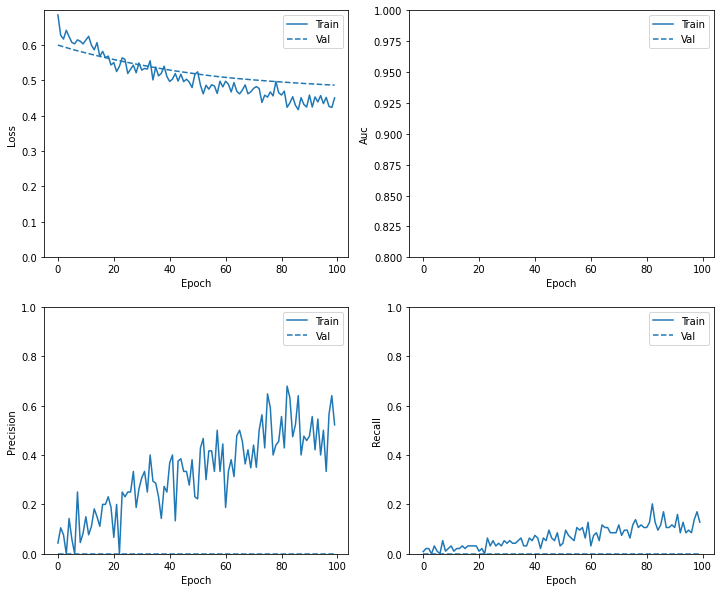

In [311]:
plot_metrics(baseline_history)

In [312]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [313]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.4380524158477783
tp :  2.0
fp :  2.0
tn :  141.0
fn :  28.0
accuracy :  0.8265895843505859
precision :  0.5
recall :  0.06666667014360428
auc :  0.6622377634048462

Legitimate Transactions Detected (True Negatives):  141
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  28
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  30


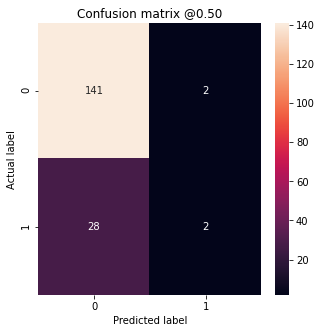

In [314]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [315]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

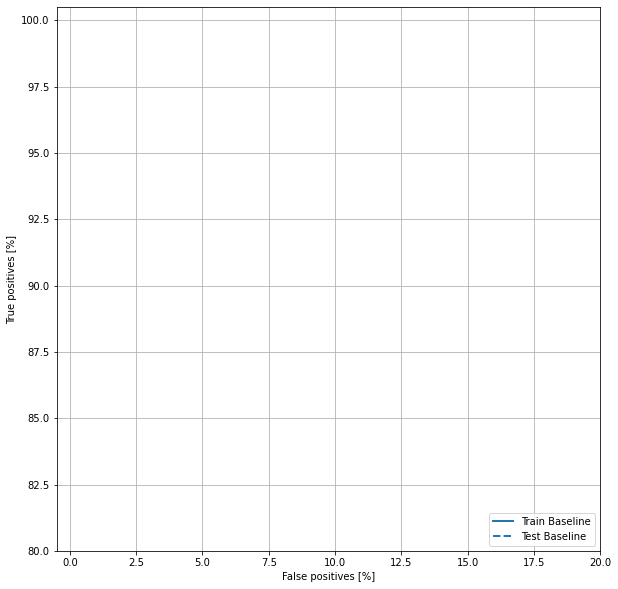

In [316]:
import sklearn
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [317]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg)*(total)/2.0 
# weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: .6, 1: 12}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.92


In [341]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight={0: .02, 1: 22}) 

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 10.5519 - tp: 10.0000 - fp: 39.0000 - tn: 562.0000 - fn: 114.0000 - accuracy: 0.7890 - precision: 0.2041 - recall: 0.0806 - auc: 0.4344 - val_loss: 0.5997 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 113.0000 - val_fn: 24.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3326
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 10.6796 - tp: 0.0000e+00 - fp: 20.0000 - tn: 438.0000 - fn: 94.0000 - accuracy: 0.7935 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3719 - val_loss: 0.5977 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 113.0000 - val_fn: 24.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 10.1615 - tp: 1.0000 - fp: 21.0000 - tn: 437.0000 - fn: 93.0000 - accuracy: 0.7935 - precision: 0.0455 - recall: 0.0106 - auc: 0

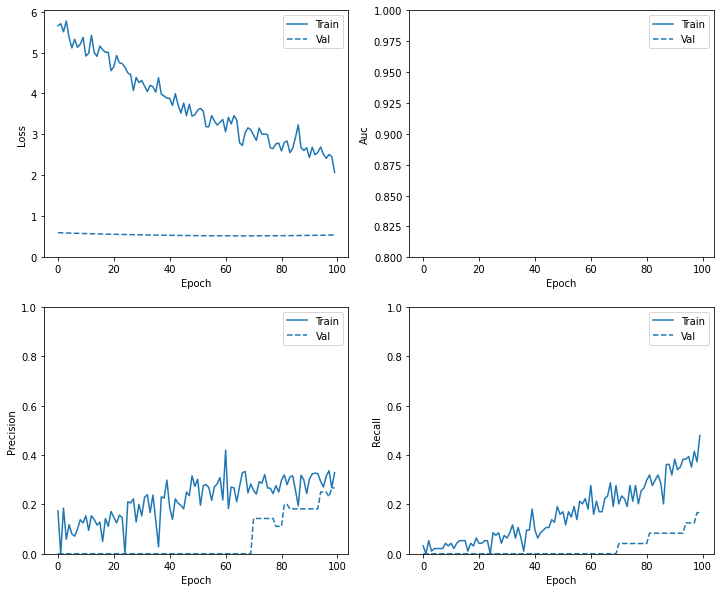

In [319]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5384306907653809
tp :  8.0
fp :  23.0
tn :  120.0
fn :  22.0
accuracy :  0.7398843765258789
precision :  0.25806450843811035
recall :  0.2666666805744171
auc :  0.6487178802490234

Legitimate Transactions Detected (True Negatives):  120
Legitimate Transactions Incorrectly Detected (False Positives):  23
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  8
Total Fraudulent Transactions:  30


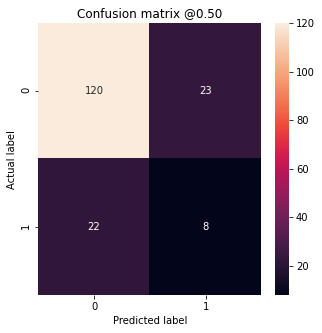

In [343]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [322]:
bool_train_labels = train_labels != 0
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [276]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]


In [324]:
res_pos_labels = pos_labels[choices]
res_pos_features.shape

(458, 24)

In [325]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(916, 24)

In [326]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [327]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.76471422  0.88624171 -0.86458319  0.06674788  0.3182399   0.94019096
 -1.17334924 -0.97142265 -0.87382966  4.24670257 -0.09560736 -0.09560736
 -0.12126781 -0.53380726 -0.6178045   1.66637608 -0.41250726 -0.26081074
 -0.1613143  -0.47895581 -0.82329311 -0.10482848  0.40369248 -0.12249559]

Label:  1


In [328]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [329]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0372 - tp: 240.0000 - fp: 379.0000 - tn: 799.0000 - fn: 803.0000 - accuracy: 0.4678 - precision: 0.3877 - recall: 0.2301 - auc: 0.4288 - val_loss: 0.6947 - val_tp: 2.0000 - val_fp: 25.0000 - val_tn: 89.0000 - val_fn: 22.0000 - val_accuracy: 0.6594 - val_precision: 0.0741 - val_recall: 0.0833 - val_auc: 0.3311
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 1.0346 - tp: 263.0000 - fp: 386.0000 - tn: 649.0000 - fn: 750.0000 - accuracy: 0.4453 - precision: 0.4052 - recall: 0.2596 - auc: 0.4163 - val_loss: 0.6934 - val_tp: 2.0000 - val_fp: 25.0000 - val_tn: 89.0000 - val_fn: 22.0000 - val_accuracy: 0.6594 - val_precision: 0.0741 - val_recall: 0.0833 - val_auc: 0.3341
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 1.0379 - tp: 265.0000 - fp: 358.0000 - tn: 629.0000 - fn: 796.0000 - accuracy: 0.4365 - precision: 0.4254 - recall: 0.2498 - auc: 0.4174 - val_loss: 0.6920 - va

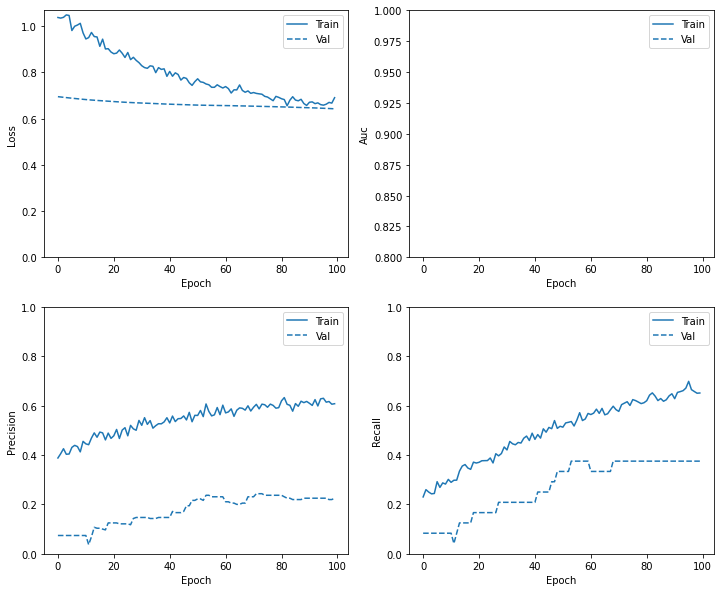

In [330]:
plot_metrics(resampled_history)

In [ ]:
tf.random.set_seed(1234)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds),
    class_weight={0:.6, 1:8} ##{0:.6, 1:5}
    )

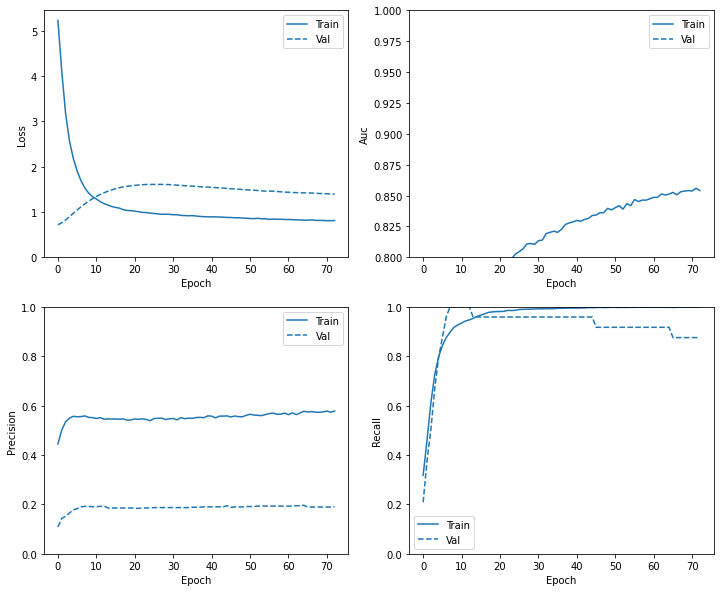

In [355]:
plot_metrics(resampled_history)

In [358]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(np.array(X_test), batch_size=BATCH_SIZE)
valid_predictions_resampled = resampled_model.predict(np.array(X_val), batch_size=BATCH_SIZE)

In [365]:
test_predictions_resampled = resampled_model.predict(np.array(X_test), batch_size=BATCH_SIZE)

loss :  1.524175763130188
tp :  29.0
fp :  101.0
tn :  42.0
fn :  1.0
accuracy :  0.41040462255477905
precision :  0.2230769246816635
recall :  0.9666666388511658
auc :  0.7744754552841187

Legitimate Transactions Detected (True Negatives):  43
Legitimate Transactions Incorrectly Detected (False Positives):  100
Fraudulent Transactions Missed (False Negatives):  1
Fraudulent Transactions Detected (True Positives):  29
Total Fraudulent Transactions:  30


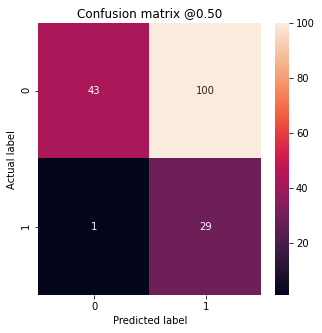

In [357]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [376]:
test_matrix

{'Actual_labels':      index  Ab_ind
 0      687       1
 1      737       0
 2      155       1
 3      538       0
 4      542       0
 5      227       0
 6       78       0
 7      446       0
 8       66       0
 9       15       1
 10     550       0
 11     119       0
 12     768       0
 13     104       0
 14     156       0
 15     190       0
 16      16       0
 17     575       0
 18     674       0
 19     771       1
 20     662       0
 21     248       1
 22     582       1
 23     438       0
 24     314       0
 25      43       0
 26     366       1
 27     732       1
 28      17       0
 29     551       1
 30     584       0
 31     668       0
 32     118       0
 33     191       0
 34     335       0
 35     660       0
 36     271       0
 37     474       0
 38     577       1
 39     545       0
 40     603       0
 41     513       0
 42     623       0
 43     562       0
 44      42       0
 45     455       0
 46     145       0
 47     798       0
 48

In [375]:
test_matrix = pd.DataFrame(test_matrix)
valid_matrix = pd.DataFrame(valid_matrix)
valid_matrix = valid_matrix.reset_index()
test_matrix = test_matrix.reset_index()

ValueError: ignored

In [366]:
test_matrix['h2o_XGB'] = h2o_XGB_model_prediction_test['predict']
test_matrix['h2o_GBM'] = h2o_GM_model_prediction_test['predict']
test_matrix['h2o_RF'] = h2o_RF_model_prediction_test['predict']
valid_matrix['h2o_XGB'] = h2o_XGB_model_prediction['predict']
valid_matrix['h2o_GBM'] = h2o_GM_model_prediction['predict']
valid_matrix['h2o_RF'] = h2o_RF_model_prediction['predict']
valid_matrix['Neural_net'] = valid_predictions_resampled
test_matrix['Neural_net'] = test_predictions_resampled
# valid_matrix = valid_matrix.drop("Actual_labels", axis=1)
# test_matrix = test_matrix.drop("Actual_labels", axis=1)
Y_val = Y_val.reset_index()
Y_test = Y_test.reset_index()

In [367]:
valid_matrix['Actual_labels'] = Y_val["Ab_ind"]
test_matrix['Actual_labels'] = Y_test["Ab_ind"]

In [368]:
# test_matrix = test_matrix.iloc[:,1:]
# valid_matrix = valid_matrix.iloc[:,1:]

In [369]:
test_matrix['STACK'] = (test_matrix['Logistic'] + 
                        test_matrix['SVM'] +
                        test_matrix['CatBoost'] +
                        test_matrix['LGBM'] +
                        test_matrix['h2o_XGB'] +
                        test_matrix['h2o_GBM'] +
                        test_matrix['h2o_RF'],
                        test_matrix['Neural_net'])
valid_matrix['STACK'] = (valid_matrix['Logistic'] + 
                        valid_matrix['SVM'] +
                        valid_matrix['CatBoost'] +
                        valid_matrix['LGBM'] +
                        valid_matrix['h2o_XGB'] +
                        valid_matrix['h2o_GBM'] +
                        valid_matrix['h2o_RF'],
                         valid_matrix['Neural_net'])

test_matrix['STACK'] = test_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 2 
                                                else 0)
valid_matrix['STACK'] = valid_matrix['STACK'].map(lambda 
                                                x: x + 1 - x 
                                                if x >= 2 
                                                else 0)

KeyError: ignored

In [220]:
confusion_matrix(valid_matrix["Actual_labels"], valid_matrix['STACK'])
confusion_matrix(test_matrix["Actual_labels"], test_matrix['STACK'])



---

---

---

---







